Importação das bibliotecas necessárias

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

** learning rate ideal**

In [ ]:
# Funcionamento
# Durante um curto treinamento:
  # Começa com uma taxa de aprendizado muito baixa (start_lr)
  # Aumenta exponencialmente a cada batch até uma taxa muito alta (end_lr)
  # Registra a perda (loss) e o valor da taxa de aprendizado a cada passo
  # Quando a perda explode ou um número de iterações é alcançado, o processo é interrompido

class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-7, end_lr=10, num_iter=100):
        super().__init__()
        self.start_lr = start_lr # taxa de aprendizado inicial
        self.end_lr = end_lr # taxa de aprendizado final
        self.num_iter = num_iter # número de passos (batches) durante os quais a taxa será aumentada
        self.lrs = []
        self.losses = []
        self.best_loss = 1e9


    # Define a learning rate inicial (start_lr) no otimizador
    # Garante que ela seja uma tf.Variable, pois vai ser modificada durante o treinamento
    def on_train_begin(self, logs=None):
        self.step = 0
        if not isinstance(self.model.optimizer.learning_rate, tf.Variable):
            self.model.optimizer.learning_rate = tf.Variable(self.start_lr, dtype=tf.float32)
        self.model.optimizer.learning_rate.assign(self.start_lr)

    # Chamado após cada batch de treinamento:
    #   Registra o lr e loss atual
    #   Se a perda for muito alta (10x a melhor perda anterior), interrompe o treino
    #   Calcula a próxima learning rate, exponencialmente:
    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        loss = logs["loss"]
        self.lrs.append(lr)
        self.losses.append(loss)
        self.step += 1

        if self.step > self.num_iter or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        new_lr = lr * (self.end_lr / self.start_lr) ** (1 / self.num_iter)
        self.model.optimizer.learning_rate.assign(new_lr)

    # Gera o gráfico de perda vs. taxa de aprendizado (em escala logarítmica no eixo X)
    # O ideal é escolher a learning rate em um trecho onde a perda cai rapidamente, mas antes de começar a subir novamente
    def plot(self):
        plt.figure(figsize=(8,6))
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.grid(True)
        plt.show()

**construtor da classe**

In [ ]:
# Parâmetros
#   X: dados de entrada (features), normalmente uma matriz 2D, onde cada linha é uma amostra e cada coluna uma característica.
#   Y: rótulos (classes) correspondentes a cada amostra, em formato 1D.
#   test_size: proporção dos dados que será usada como conjunto de validação (default 20%).
#   random_state: semente para garantir que a divisão dos dados seja reprodutível.
#   apply_pca: booleano para indicar se deve aplicar PCA (redução de dimensionalidade).
#   pca_components: número de componentes principais a serem usados no PCA.
class MulticlassClassificationPipeline:
    def __init__(self, X, Y, test_size=0.2, random_state=42, apply_pca=False, pca_components=50):
        # Split train/val
        self.X_train_raw, self.X_val_raw, self.Y_train, self.Y_val = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, stratify=Y)

        # Optionally apply PCA
        self.apply_pca = apply_pca
        self.pca_components = pca_components
        if self.apply_pca:
            print(f"Aplicando PCA com {pca_components} componentes...")
            self.pca = PCA(n_components=pca_components)
            self.X_train = self.pca.fit_transform(self.X_train_raw)
            self.X_val = self.pca.transform(self.X_val_raw)
        else:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(self.X_train_raw)
            self.X_val = self.scaler.transform(self.X_val_raw)

        self.num_features = self.X_train.shape[1]
        self.num_classes = len(np.unique(self.Y_train))
        self.history = {}


# Em resumo
# Este método prepara os dados para o pipeline de classificação:
  # Divide em treino e validação de forma estratificada
  # Aplica PCA ou normalização nos dados de treino e validação
  # Define propriedades para facilitar a criação dos modelos (número de features e classes)
  # Prepara estrutura para armazenar resultados do treino

##############################################################################################


    # Entrada: vetor com num_features características.
    # Camada oculta: uma camada densa com 512 neurônios e função de ativação ReLU (ativa não linearidade).
    # Saída: camada densa com num_classes neurônios, ativação softmax para classificação multiclasse (gera probabilidades).
    # Modelo: uma rede simples de duas camadas (uma oculta + saída).
    def build_model_base(self):
          inputs = layers.Input(shape=(self.num_features,))
          x = layers.Dense(512, activation='relu')(inputs)
          outputs = layers.Dense(self.num_classes, activation='softmax')(x)
          model = models.Model(inputs=inputs, outputs=outputs, name="modelobase")
          return model


    # Entrada: vetor com num_features.
    # Primeira camada: densa com 256 neurônios e ReLU.
    # Blocos residuais (dois blocos): cada bloco tem duas camadas densas de 256 neurônios com ReLU. A saída do bloco é somada à entrada do bloco (layers.Add()), criando uma conexão residual (skip connection).
    # Ativação: ReLU aplicada após cada soma residual.
    # Saída: camada densa com num_classes neurônios e softmax.
    # Objetivo: usar blocos residuais para melhorar o fluxo do gradiente, facilitando o aprendizado em redes mais profundas.
    def build_model_blocks(self):
        inputs = layers.Input(shape=(self.num_features,))
        x = layers.Dense(256, activation='relu')(inputs)
        # Bloco 1
        x1 = layers.Dense(256, activation='relu')(x)
        x1 = layers.Dense(256, activation='relu')(x1)
        x = layers.Add()([x, x1])  # bloco residual simples
        x = layers.Activation('relu')(x)
        # Bloco 2
        x2 = layers.Dense(256, activation='relu')(x)
        x2 = layers.Dense(256, activation='relu')(x2)
        x = layers.Add()([x, x2])
        x = layers.Activation('relu')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelobasebloco")
        return model


    # Semelhante ao build_model_base, porém a entrada é o vetor transformado por PCA (dimensão reduzida para pca_components).
    # Camada oculta: 256 neurônios com ReLU.
    # Saída: softmax com num_classes.
    # Usado quando o pipeline aplicou PCA antes.
    def build_model_base_pca(self):
        # Aplica PCA antes do pipeline (deve ter sido ativado no init)
        # Aqui só cria o modelo base, mas lembrando que X já vem com PCA aplicado
        inputs = layers.Input(shape=(self.pca_components,))
        x = layers.Dense(256, activation='relu')(inputs)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelobasepca")
        return model


    # Entrada: vetor com num_features.
    # Primeira camada oculta: densa 256 neurônios, seguida por:
    #     BatchNormalization: normaliza a saída da camada, acelerando o treinamento e ajudando na estabilidade.
    #     ReLU: ativação não linear.
    #     Dropout(0.3): técnica de regularização que "desliga" 30% dos neurônios aleatoriamente para evitar overfitting.
    # Segunda camada oculta: mesma estrutura da primeira.
    # Saída: camada densa com softmax.
    # Objetivo: modelo com normalização, ativação e regularização para melhor generalização.
    def build_model_customizado(self):
        inputs = layers.Input(shape=(self.num_features,))
        x = layers.Dense(256)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelocustomizado")
        return model


    # Executa um curto treino para variar a learning rate exponencialmente de um valor baixo até um valor alto.
    # O callback LearningRateFinder registra a loss para cada valor de learning rate.
    # O gráfico ajuda a visualizar a faixa ideal de learning rate para o treino (onde a loss cai rapidamente sem explodir).
    # Auxilia na escolha de um valor de learning rate para treino final.
    def find_best_lr(self, model, X_train_data, Y_train_data, epochs=1, batch_size=64):
        print(f"\nIniciando Learning Rate Finder para {model.name}...")
        lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1, num_iter=50)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr_finder.start_lr),
                      loss='sparse_categorical_crossentropy')
        model.fit(X_train_data, Y_train_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[lr_finder],
                  verbose=0)
        lr_finder.plot()
        print("📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).")


    # Compila o modelo para o treino completo com o learning rate final.
    # Utiliza callbacks para parar cedo se não houver melhora e para reduzir learning rate se necessário.
    # Treina o modelo, monitorando desempenho na validação.
    # Salva o histórico do treino para posterior análise.
    def train(self, model, X_train_data, Y_train_data, X_val_data, Y_val_data,
              epochs=25, batch_size=64, learning_rate=0.001):
        print(f"\nTreinando {model.name}...")

        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        callbacks_list = [
            callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
        ]

        history = model.fit(X_train_data, Y_train_data,
                            validation_data=(X_val_data, Y_val_data),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=callbacks_list,
                            verbose=2)
        self.history[model.name] = {'history': history, 'model': model,
                                    'X_val': X_val_data, 'Y_val': Y_val_data}
        return history


    # Avalia o desempenho do modelo na validação.
    # Retorna métricas comuns para classificação: precisão, revocação e F1-score.
    # Gera a matriz de confusão para análise detalhada dos acertos e erros.
    def evaluate(self, model, X_val_data, Y_val_data):
        y_pred_probs = model.predict(X_val_data)
        y_pred = np.argmax(y_pred_probs, axis=1)
        precision = precision_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        recall = recall_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(Y_val_data, y_pred)
        return (precision, recall, f1), cm


    # Para cada modelo treinado, plota os gráficos de perda (loss) e acurácia (accuracy) durante o treino.
    # Compara o desempenho no conjunto de treino e validação.
    # Ajuda a diagnosticar overfitting, underfitting e comportamento do treinamento.
    def plot_loss_accuracy(self, histories):
        for model_name, data in self.history.items():
            history = data['history']

            plt.figure(figsize=(12,5))

            plt.subplot(1,2,1)
            plt.plot(history.history['loss'], label='Treino')
            plt.plot(history.history['val_loss'], label='Validação')
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Épocas')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(history.history.get('accuracy', []), label='Treino')
            plt.plot(history.history.get('val_accuracy', []), label='Validação')
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Épocas')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()


    # Plota a matriz de confusão usando seaborn.heatmap.
    # Eixos representam as classes verdadeiras e preditas.
    # Células mostram quantas vezes cada classe foi prevista corretamente ou incorretamente.
    # Útil para analisar quais classes o modelo confunde com mais frequência.
    def plot_confusion_matrix(self, cm, class_names, model_name):
        plt.figure(figsize=(12,10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Matriz de Confusão - {model_name}')
        plt.show()

    # Orquestrar a execução completa do experimento com diferentes arquiteturas de modelos, incluindo:
      # Construção,
      # Ajuste da learning rate,
      # Treinamento,
      # Avaliação,
      # Exibição dos resultados.
    def run_all_models(self):
        print("Rodando todos os modelos...\n")

        histories = []

        # Modelo Base
        # Cria o modelo base simples.
        # Define o nome para identificar no histórico.
        # Executa o processo para encontrar a melhor learning rate.
        # Treina o modelo com a learning rate escolhida.
        # Salva o modelo e o histórico para análise posterior.
        print("Treinando Modelo Base...")
        model_base = self.build_model_base()
        model_base.name = "modelobase"
        self.find_best_lr(model_base, self.X_train, self.Y_train)
        history_base = self.train(model_base, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_base, history_base))

        # Modelo Base + Blocos
        # Cria o modelo base com blocos residuais (mais complexo).
        # Ajusta learning rate e treina, salvando resultados.
        print("\nTreinando Modelo Base + Blocos...")
        model_blocks = self.build_model_blocks()
        model_blocks.name = "modelobaseblocos"
        self.find_best_lr(model_blocks, self.X_train, self.Y_train)
        history_blocks = self.train(model_blocks, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_blocks, history_blocks))

        # Modelo Base + PCA (ativação condicional)
        # Junta os dados de treino e validação originais.
        # Cria um novo pipeline ativando o PCA.
        # Executa o run_all_models nesse novo pipeline (recursivamente).
        # Interrompe a execução atual para evitar duplicidade.
        if not self.apply_pca:
            print("\n[Info] Aplicando PCA para o modelo PCA. Criando novo pipeline com PCA ativado.\n")
            # Recria pipeline com PCA ativo
            pipeline_pca = MulticlassClassificationPipeline(
                np.vstack([self.X_train_raw, self.X_val_raw]),
                np.hstack([self.Y_train, self.Y_val]),
                test_size=0.2,
                random_state=42,
                apply_pca=True,
                pca_components=self.pca_components
            )
            pipeline_pca.run_all_models()
            return

        # Modelo Base + PCA
        # Cria o modelo base que já assume os dados com PCA.
        # Ajusta learning rate, treina e salva o histórico.
        print("\nTreinando Modelo Base + PCA...")
        model_pca = self.build_model_base_pca()
        model_pca.name = "modelobasepca"
        self.find_best_lr(model_pca, self.X_train, self.Y_train)
        history_pca = self.train(model_pca, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_pca, history_pca))

        # Modelo Customizado
        # Cria um modelo com normalização, dropout e camadas densas personalizadas.
        # Ajusta learning rate, treina e armazena resultados.
        print("\nTreinando Modelo Customizado...")
        model_custom = self.build_model_customizado()
        model_custom.name = "modelocustomizado"
        self.find_best_lr(model_custom, self.X_train, self.Y_train)
        history_custom = self.train(model_custom, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_custom, history_custom))

        # Avaliação + Matriz de confusão
        # Para cada modelo treinado:
        #   Avalia usando o conjunto de validação.
        #   Imprime métricas ponderadas de precisão, recall e F1.
        #   Plota a matriz de confusão para análise detalhada dos erros e acertos.
        for model, _ in histories:
            print(f"\n[Avaliação] {model.name}")
            (precision, recall, f1), cm = self.evaluate(model, self.X_val, self.Y_val)
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
            class_names = [f"Classe {i}" for i in range(self.num_classes)]
            self.plot_confusion_matrix(cm, class_names, model.name)

        self.plot_loss_accuracy(histories)

**Execução**

In [ ]:
if __name__ == "__main__":

    # Importa o backend do Keras e limpa a sessão atual do TensorFlow para evitar erros relacionados a sessões/variáveis de modelos anteriores (útil para rodar várias vezes no mesmo ambiente, como Jupyter).
    from tensorflow.keras import backend as K
    K.clear_session()

    # Faz o download e carregamento do dataset RCV1 (Reuters Corpus Volume I), que é um conjunto de dados para classificação multilabel de textos.
    # Pega os primeiros 1000 exemplos para trabalhar de forma mais rápida.
    # Converte a matriz esparsa para array denso (toarray()) e para float32 para compatibilidade com TensorFlow.
    # Y_multi é uma matriz multilabel (cada amostra pode pertencer a múltiplas classes).
    print("Carregando dados RCV1 (multiclasse adaptado)...")
    rcv1 = fetch_rcv1(shuffle=True, download_if_missing=True)
    X = rcv1.data[:1000].toarray().astype(np.float32)
    Y_multi = rcv1.target[:1000].toarray()

    # Converter multilabel para multiclass selecionando o primeiro label ativo
    # Define uma função para converter o problema multilabel em multiclass (uma classe por amostra).
    # Essa conversão é feita selecionando a primeira classe ativa (posição do maior valor em cada linha).
    # Aplica essa função para gerar Y_initial, os rótulos multiclasses.
    def multilabel_to_multiclass(Y):
        idxs = np.argmax(Y, axis=1)
        return idxs

    Y_initial = multilabel_to_multiclass(Y_multi)

    # Filtrar classes com >= 2 amostras
    # Conta quantas amostras cada classe tem.
    # Seleciona apenas as classes que têm pelo menos 2 amostras, para evitar classes muito raras e garantir dados suficientes para treino e validação.
    # Exibe as classes válidas.
    counts = Counter(Y_initial)
    valid_classes = [cls for cls, cnt in counts.items() if cnt >= 2]
    print(f"Classes válidas (>=2 amostras): {valid_classes}")

    # Cria uma máscara booleana para filtrar apenas as amostras das classes válidas.
    # Aplica essa máscara para filtrar os dados e rótulos.
    mask = np.isin(Y_initial, valid_classes)
    X = X[mask]
    Y_initial = Y_initial[mask]

    # Remapear rótulos para 0..num_classes-1
    # Ordena as classes válidas.
    # Cria um mapeamento para transformar os rótulos originais (que podem ser números grandes ou não sequenciais) para índices sequenciais de 0 até num_classes-1.
    # Aplica esse mapeamento nos rótulos para gerar Y_mapped, que é a versão final dos rótulos, pronta para treinar o modelo.
    unique_classes = sorted(valid_classes)
    label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
    Y_mapped = np.array([label_to_index[label] for label in Y_initial])
    print(f"Rótulos originais únicos: {unique_classes}")
    print(f"Rótulos mapeados únicos: {np.unique(Y_mapped)}")

    # Instancia o pipeline de classificação multiclass com os dados filtrados e rótulos mapeados.
    # Chama o método run_all_models() para executar todo o fluxo de criação, treino e avaliação dos modelos.
    pipeline = MulticlassClassificationPipeline(X, Y_mapped)
    pipeline.run_all_models()

**Notebook completo para execução única**

Carregando dados RCV1 (multiclasse adaptado)...
Classes válidas (>=2 amostras): [np.int64(4), np.int64(94), np.int64(44), np.int64(70), np.int64(22), np.int64(8), np.int64(51), np.int64(95), np.int64(98), np.int64(9), np.int64(18), np.int64(32), np.int64(2), np.int64(40), np.int64(14), np.int64(1), np.int64(93), np.int64(35), np.int64(0), np.int64(3), np.int64(21), np.int64(34), np.int64(37), np.int64(30), np.int64(20), np.int64(53), np.int64(58), np.int64(19), np.int64(27), np.int64(33), np.int64(60), np.int64(26)]
Rótulos originais únicos: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(8), np.int64(9), np.int64(14), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(26), np.int64(27), np.int64(30), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(37), np.int64(40), np.int64(44), np.int64(51), np.int64(53), np.int64(58), np.int64(60), np.int64(70), np.int64(93), np.int64(94), np.int64(95), np.int64(98)]
Rótulos ma

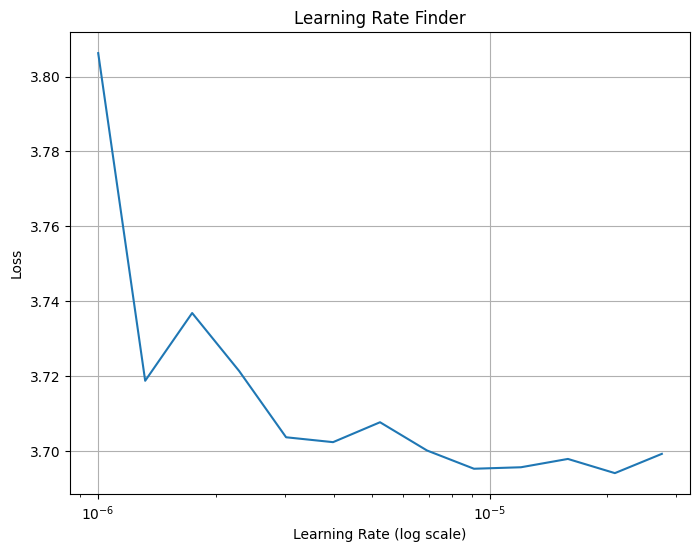

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelobase...
Epoch 1/25
13/13 - 9s - 658ms/step - accuracy: 0.2841 - loss: 6.4559 - val_accuracy: 0.5450 - val_loss: 2.2854 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 6s - 473ms/step - accuracy: 0.9675 - loss: 0.2377 - val_accuracy: 0.5750 - val_loss: 2.2051 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 10s - 783ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.6000 - val_loss: 2.2943 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 11s - 817ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.6050 - val_loss: 2.3233 - learning_rate: 1.0000e-03
Epoch 5/25

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 - 11s - 846ms/step - accuracy: 0.9987 - loss: 0.0037 - val_accuracy: 0.6050 - val_loss: 2.3372 - learning_rate: 1.0000e-03
Epoch 6/25
13/13 - 10s - 785ms/step - accuracy: 0.9987 - loss: 0.0030 - val_accuracy: 0.6050 - val_loss: 2.33

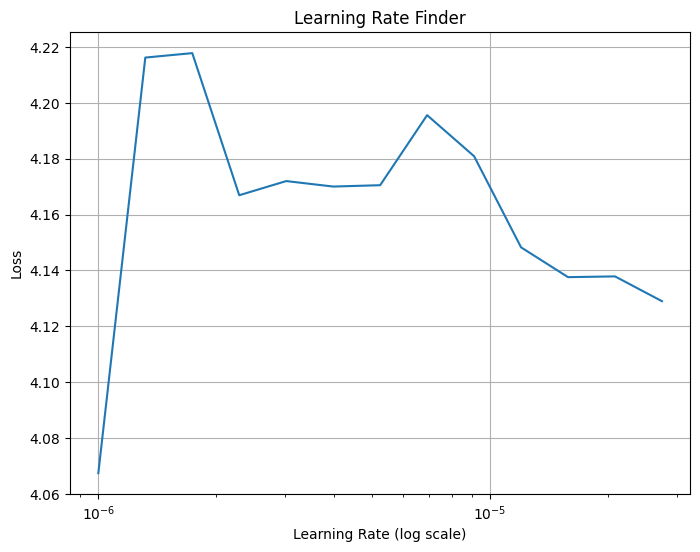

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelobaseblocos...
Epoch 1/25
13/13 - 8s - 592ms/step - accuracy: 0.3867 - loss: 2.9254 - val_accuracy: 0.5050 - val_loss: 2.0366 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 5s - 370ms/step - accuracy: 0.9537 - loss: 0.3133 - val_accuracy: 0.5600 - val_loss: 1.8497 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 4s - 339ms/step - accuracy: 0.9962 - loss: 0.0363 - val_accuracy: 0.5800 - val_loss: 1.8379 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 4s - 300ms/step - accuracy: 0.9987 - loss: 0.0110 - val_accuracy: 0.5500 - val_loss: 1.8628 - learning_rate: 1.0000e-03
Epoch 5/25
13/13 - 6s - 436ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.5450 - val_loss: 1.8684 - learning_rate: 1.0000e-03
Epoch 6/25

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 - 5s - 366ms/step - accuracy: 0.9975 - loss: 0.0059 - val_accuracy: 0.5450 - val_loss: 1.

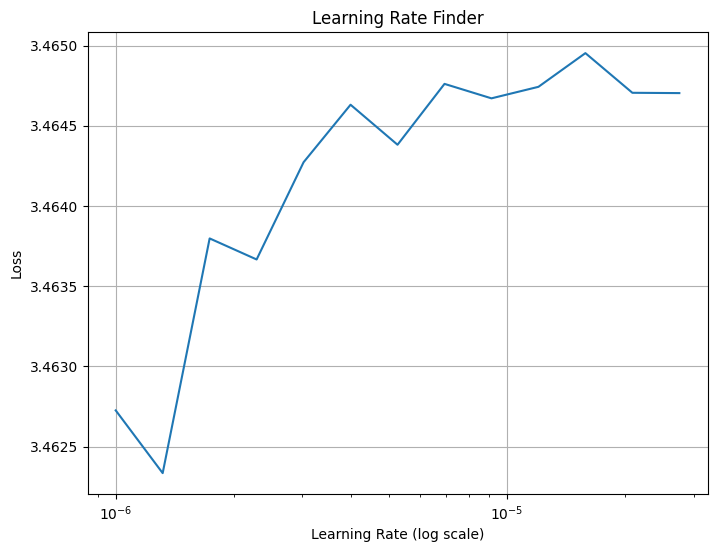

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelobase...
Epoch 1/25
13/13 - 1s - 88ms/step - accuracy: 0.2716 - loss: 3.4089 - val_accuracy: 0.4200 - val_loss: 3.3500 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 0s - 33ms/step - accuracy: 0.4481 - loss: 3.2453 - val_accuracy: 0.4400 - val_loss: 3.1766 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 0s - 10ms/step - accuracy: 0.4393 - loss: 3.0131 - val_accuracy: 0.4200 - val_loss: 2.9189 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 0s - 11ms/step - accuracy: 0.4293 - loss: 2.7218 - val_accuracy: 0.4050 - val_loss: 2.6584 - learning_rate: 1.0000e-03
Epoch 5/25
13/13 - 0s - 13ms/step - accuracy: 0.4130 - loss: 2.4748 - val_accuracy: 0.4050 - val_loss: 2.5047 - learning_rate: 1.0000e-03
Epoch 6/25
13/13 - 0s - 20ms/step - accuracy: 0.4218 - loss: 2.3201 - val_accuracy: 0.4150 - val_loss: 2.4038 - learning_rate: 1.0000e-03
Epoch 7/25
13/13 - 0s - 10ms/step - accuracy: 0.4556 - lo

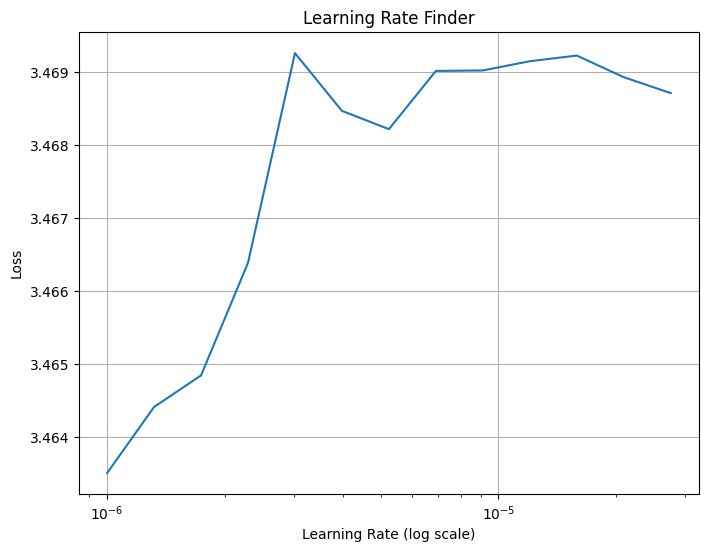

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelobaseblocos...
Epoch 1/25
13/13 - 2s - 191ms/step - accuracy: 0.2678 - loss: 3.1317 - val_accuracy: 0.3950 - val_loss: 2.6850 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 0s - 15ms/step - accuracy: 0.3930 - loss: 2.5000 - val_accuracy: 0.3750 - val_loss: 2.2926 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 0s - 24ms/step - accuracy: 0.4493 - loss: 2.0402 - val_accuracy: 0.4650 - val_loss: 2.0290 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 0s - 22ms/step - accuracy: 0.5131 - loss: 1.7608 - val_accuracy: 0.5300 - val_loss: 1.8313 - learning_rate: 1.0000e-03
Epoch 5/25
13/13 - 0s - 15ms/step - accuracy: 0.5870 - loss: 1.5069 - val_accuracy: 0.5500 - val_loss: 1.6977 - learning_rate: 1.0000e-03
Epoch 6/25
13/13 - 0s - 24ms/step - accuracy: 0.6658 - loss: 1.2853 - val_accuracy: 0.5600 - val_loss: 1.5429 - learning_rate: 1.0000e-03
Epoch 7/25
13/13 - 0s - 15ms/step - accuracy: 0.69

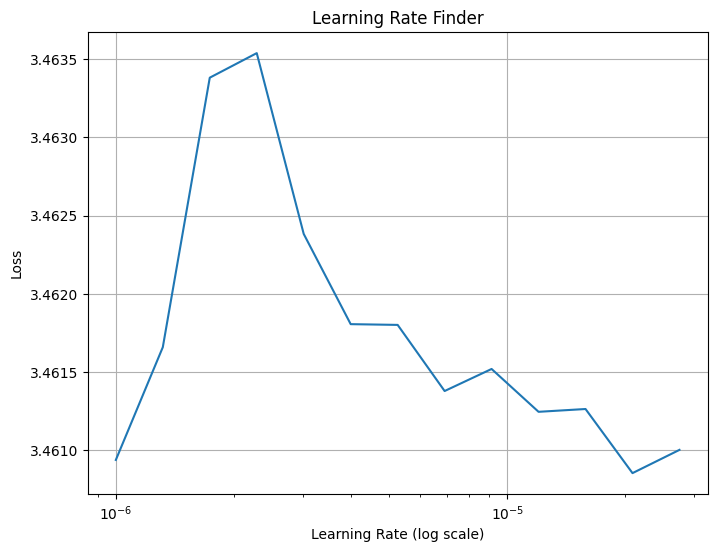

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelobasepca...
Epoch 1/25
13/13 - 1s - 90ms/step - accuracy: 0.2553 - loss: 3.4185 - val_accuracy: 0.3300 - val_loss: 3.3780 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 1s - 39ms/step - accuracy: 0.3680 - loss: 3.3086 - val_accuracy: 0.3600 - val_loss: 3.2684 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 0s - 22ms/step - accuracy: 0.3730 - loss: 3.1636 - val_accuracy: 0.3650 - val_loss: 3.1142 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 0s - 22ms/step - accuracy: 0.3792 - loss: 2.9709 - val_accuracy: 0.3700 - val_loss: 2.9178 - learning_rate: 1.0000e-03
Epoch 5/25
13/13 - 0s - 24ms/step - accuracy: 0.3792 - loss: 2.7548 - val_accuracy: 0.3650 - val_loss: 2.7200 - learning_rate: 1.0000e-03
Epoch 6/25
13/13 - 0s - 21ms/step - accuracy: 0.3892 - loss: 2.5618 - val_accuracy: 0.3850 - val_loss: 2.5794 - learning_rate: 1.0000e-03
Epoch 7/25
13/13 - 0s - 23ms/step - accuracy: 0.3905 -

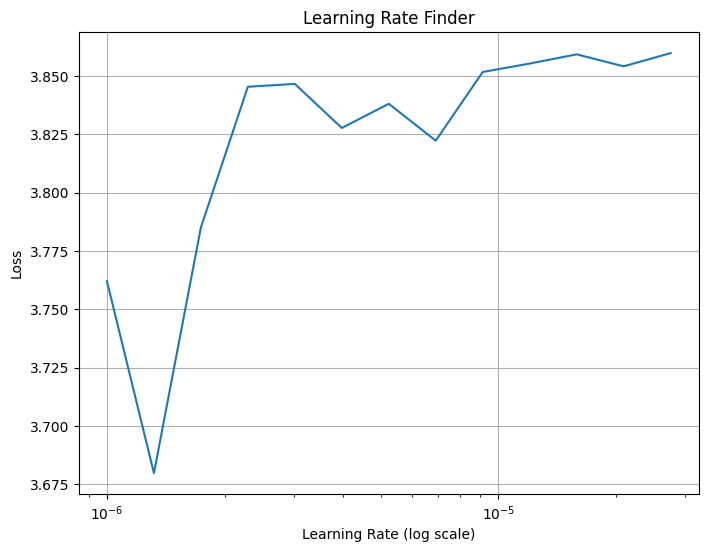

📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).

Treinando modelocustomizado...
Epoch 1/25
13/13 - 3s - 202ms/step - accuracy: 0.2153 - loss: 3.0899 - val_accuracy: 0.3400 - val_loss: 3.3630 - learning_rate: 1.0000e-03
Epoch 2/25
13/13 - 0s - 16ms/step - accuracy: 0.5219 - loss: 1.9241 - val_accuracy: 0.2850 - val_loss: 3.2634 - learning_rate: 1.0000e-03
Epoch 3/25
13/13 - 0s - 12ms/step - accuracy: 0.6070 - loss: 1.5768 - val_accuracy: 0.2600 - val_loss: 3.1812 - learning_rate: 1.0000e-03
Epoch 4/25
13/13 - 0s - 12ms/step - accuracy: 0.6633 - loss: 1.3484 - val_accuracy: 0.2450 - val_loss: 3.1149 - learning_rate: 1.0000e-03
Epoch 5/25
13/13 - 0s - 23ms/step - accuracy: 0.7259 - loss: 1.1496 - val_accuracy: 0.2400 - val_loss: 3.0520 - learning_rate: 1.0000e-03
Epoch 6/25
13/13 - 0s - 23ms/step - accuracy: 0.7297 - loss: 1.0961 - val_accuracy: 0.2450 - val_loss: 2.9939 - learning_rate: 1.0000e-03
Epoch 7/25
13/13 - 0s - 23ms/step - accuracy: 0.7

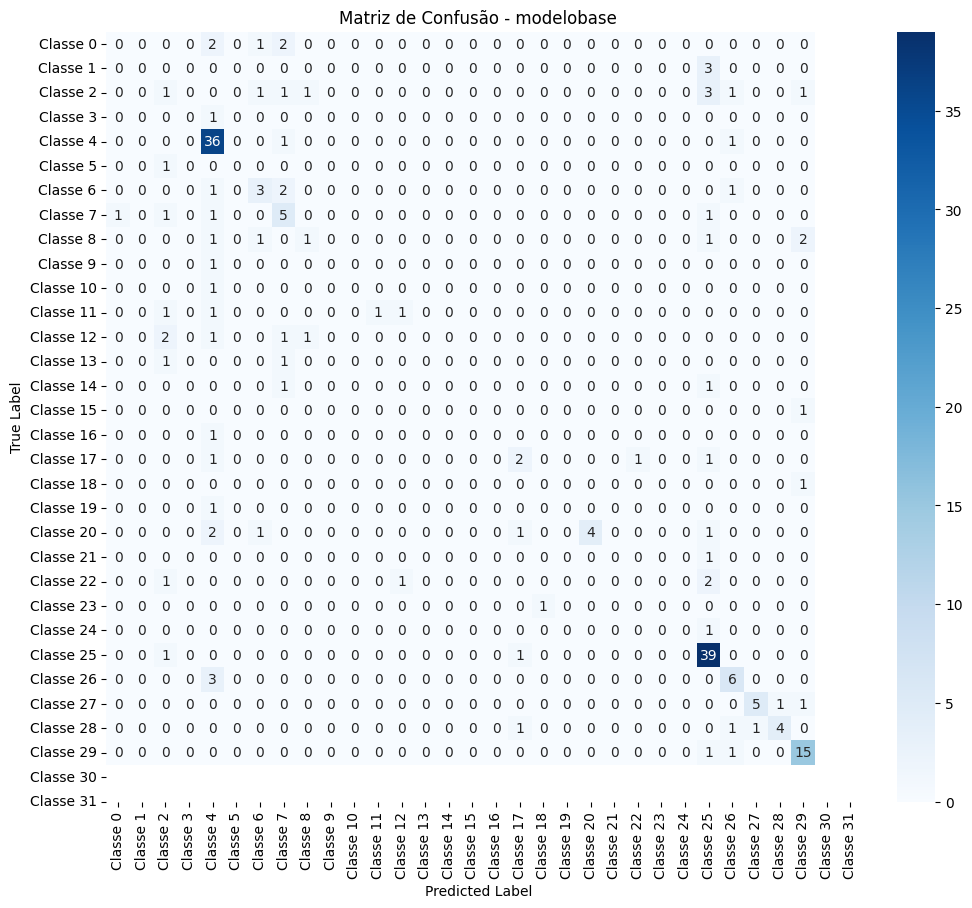


[Avaliação] modelobaseblocos
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: 0.5952, Recall: 0.6200, F1: 0.5898


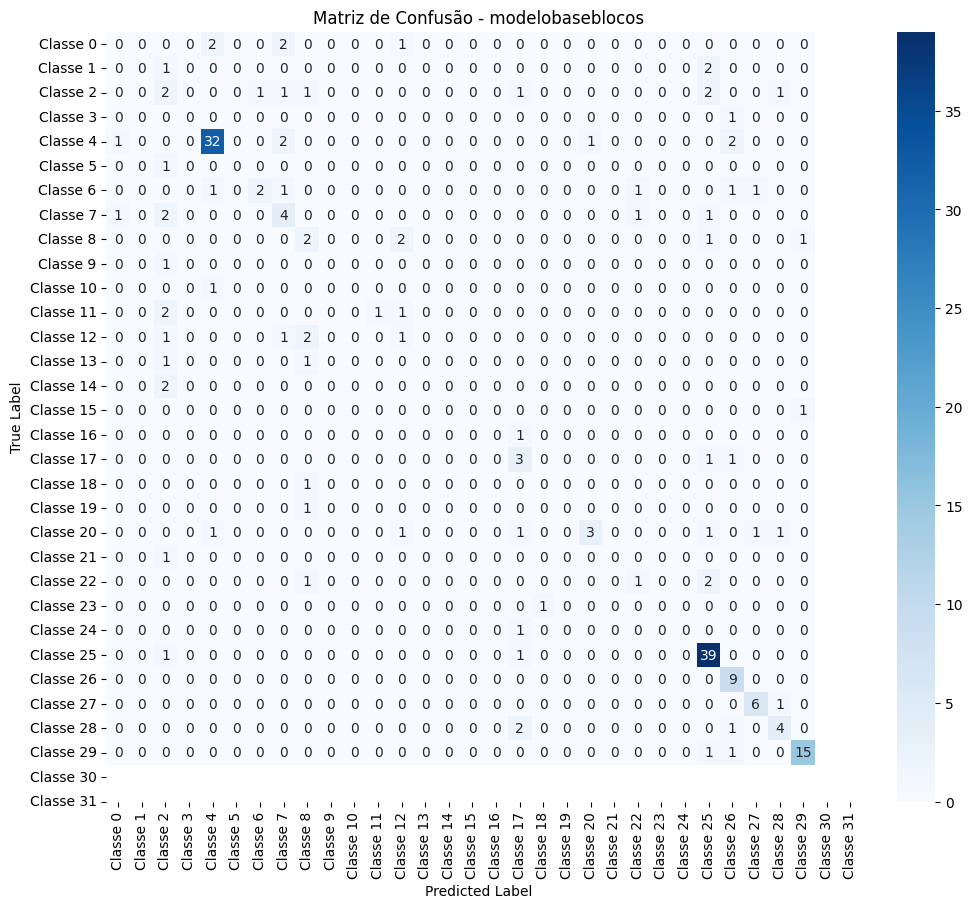


[Avaliação] modelobasepca
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Precision: 0.4703, Recall: 0.5850, F1: 0.5019


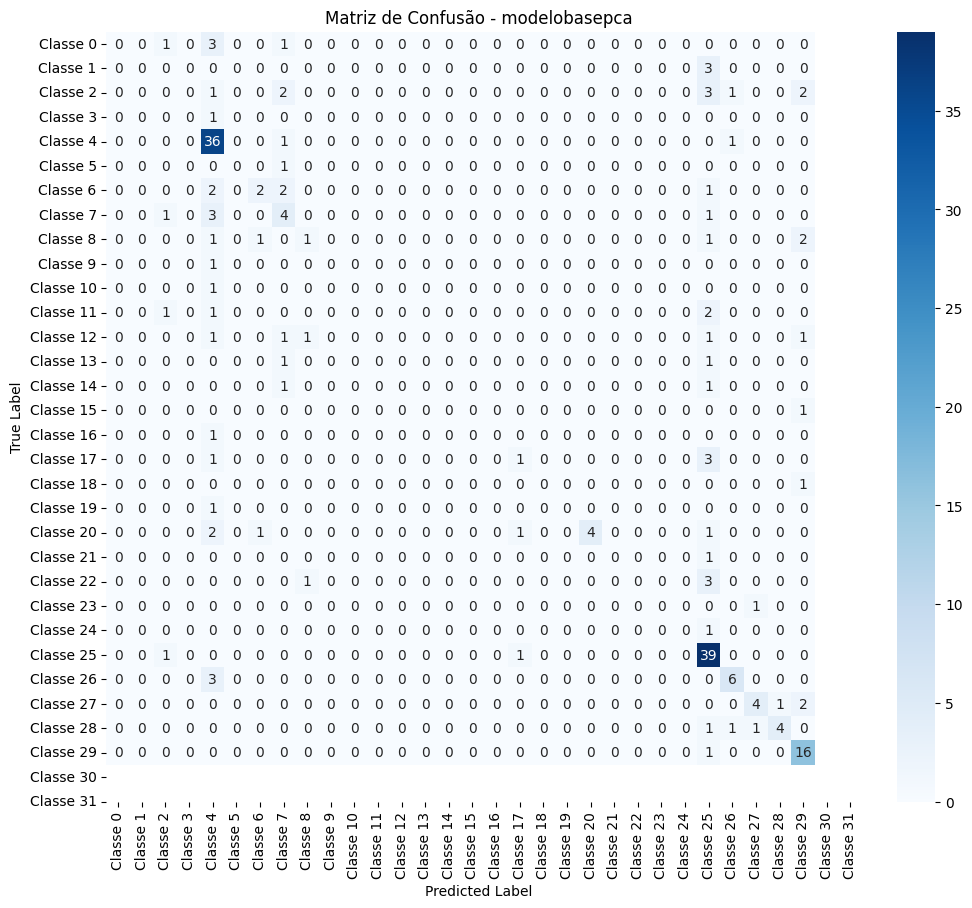


[Avaliação] modelocustomizado
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Precision: 0.4832, Recall: 0.5050, F1: 0.4264


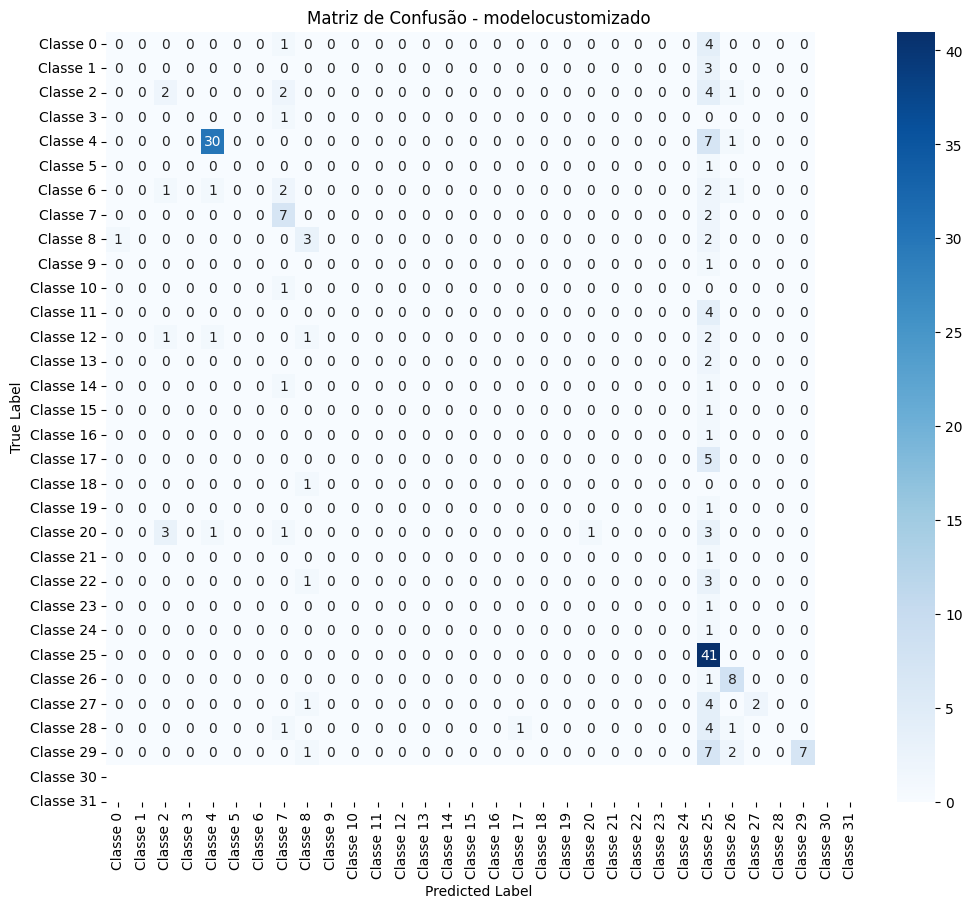

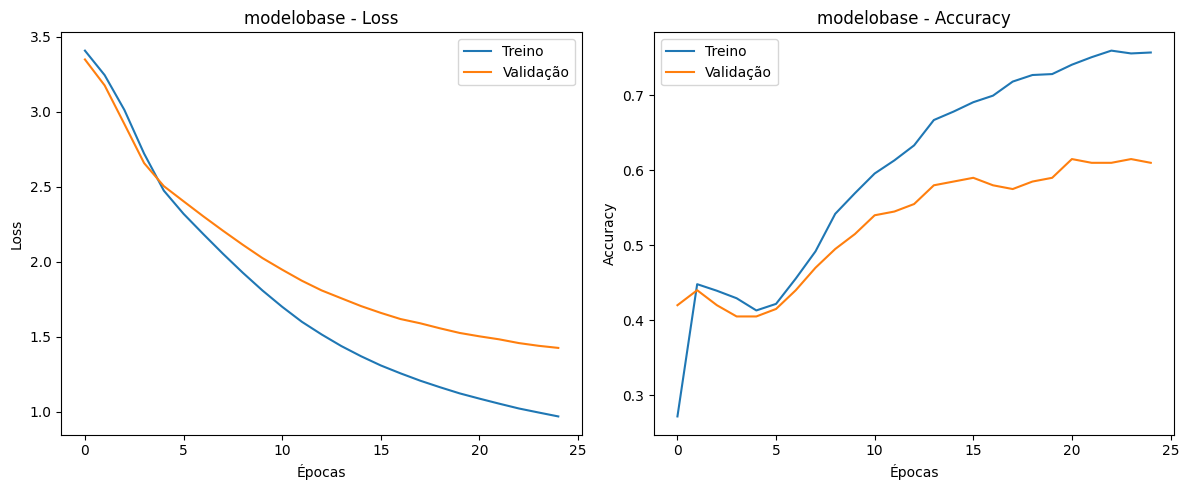

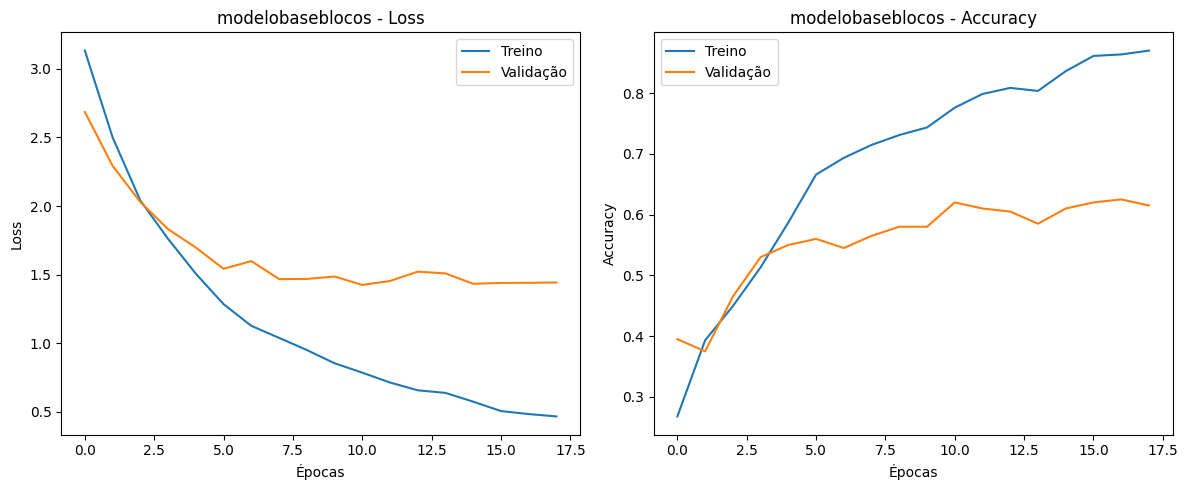

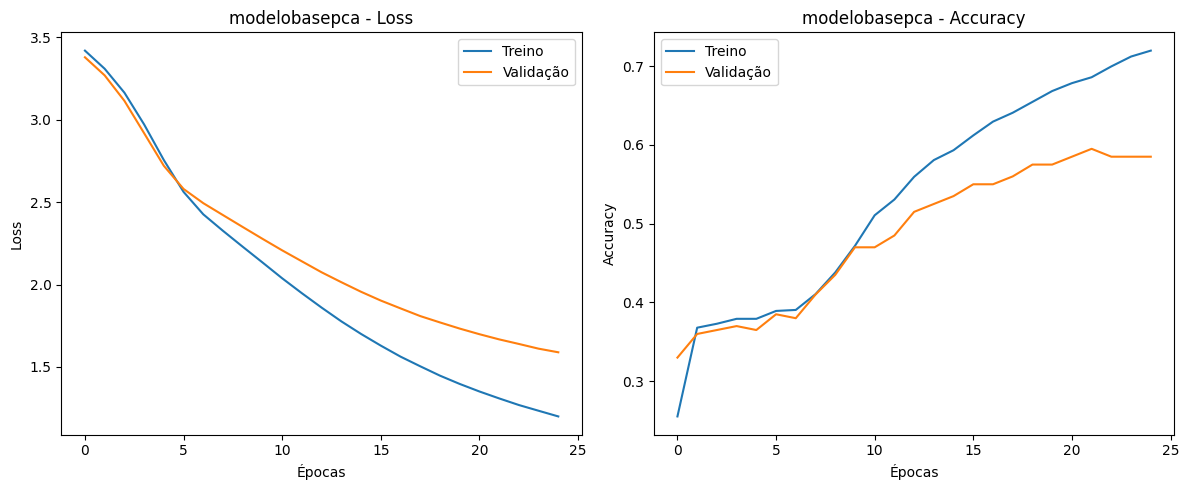

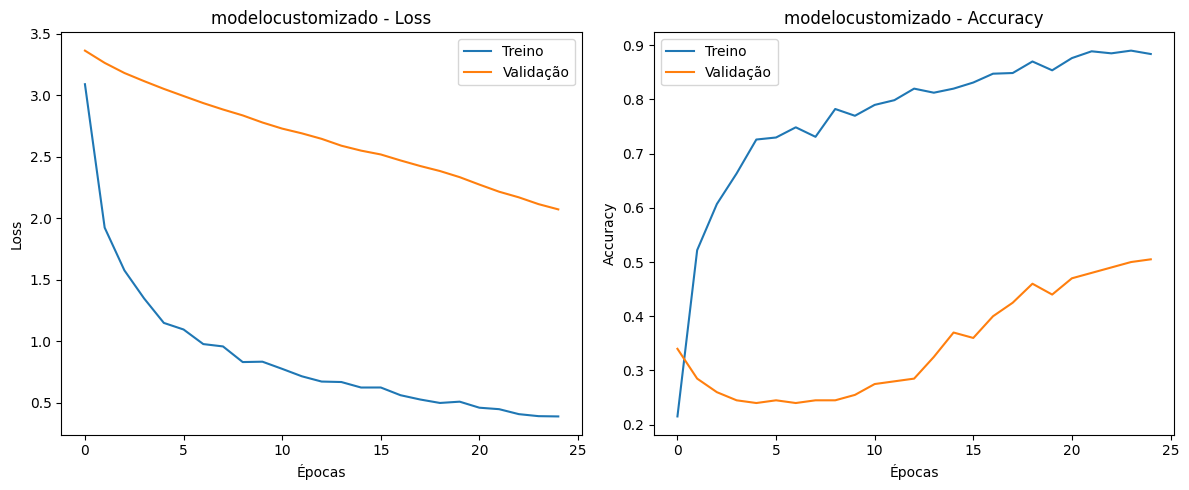

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr=1e-7, end_lr=10, num_iter=100):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.lrs = []
        self.losses = []
        self.best_loss = 1e9

    def on_train_begin(self, logs=None):
        self.step = 0
        if not isinstance(self.model.optimizer.learning_rate, tf.Variable):
            self.model.optimizer.learning_rate = tf.Variable(self.start_lr, dtype=tf.float32)
        self.model.optimizer.learning_rate.assign(self.start_lr)

    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        loss = logs["loss"]
        self.lrs.append(lr)
        self.losses.append(loss)
        self.step += 1

        if self.step > self.num_iter or loss > self.best_loss * 10:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        new_lr = lr * (self.end_lr / self.start_lr) ** (1 / self.num_iter)
        self.model.optimizer.learning_rate.assign(new_lr)

    def plot(self):
        plt.figure(figsize=(8,6))
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        plt.xlabel('Learning Rate (log scale)')
        plt.ylabel('Loss')
        plt.title('Learning Rate Finder')
        plt.grid(True)
        plt.show()

class MulticlassClassificationPipeline:
    def __init__(self, X, Y, test_size=0.2, random_state=42, apply_pca=False, pca_components=50):
        # Split train/val
        self.X_train_raw, self.X_val_raw, self.Y_train, self.Y_val = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, stratify=Y)

        # Optionally apply PCA
        self.apply_pca = apply_pca
        self.pca_components = pca_components
        if self.apply_pca:
            print(f"Aplicando PCA com {pca_components} componentes...")
            self.pca = PCA(n_components=pca_components)
            self.X_train = self.pca.fit_transform(self.X_train_raw)
            self.X_val = self.pca.transform(self.X_val_raw)
        else:
            self.scaler = StandardScaler()
            self.X_train = self.scaler.fit_transform(self.X_train_raw)
            self.X_val = self.scaler.transform(self.X_val_raw)

        self.num_features = self.X_train.shape[1]
        self.num_classes = len(np.unique(self.Y_train))
        self.history = {}

    def build_model_base(self):
        inputs = layers.Input(shape=(self.num_features,))
        x = layers.Dense(512, activation='relu')(inputs)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelobase")
        return model

    def build_model_blocks(self):
        inputs = layers.Input(shape=(self.num_features,))
        x = layers.Dense(256, activation='relu')(inputs)
        # Bloco 1
        x1 = layers.Dense(256, activation='relu')(x)
        x1 = layers.Dense(256, activation='relu')(x1)
        x = layers.Add()([x, x1])  # bloco residual simples
        x = layers.Activation('relu')(x)
        # Bloco 2
        x2 = layers.Dense(256, activation='relu')(x)
        x2 = layers.Dense(256, activation='relu')(x2)
        x = layers.Add()([x, x2])
        x = layers.Activation('relu')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelobasebloco")
        return model

    def build_model_base_pca(self):
        # Aplica PCA antes do pipeline (deve ter sido ativado no init)
        # Aqui só cria o modelo base, mas lembrando que X já vem com PCA aplicado
        inputs = layers.Input(shape=(self.pca_components,))
        x = layers.Dense(256, activation='relu')(inputs)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelobasepca")
        return model

    def build_model_customizado(self):
        inputs = layers.Input(shape=(self.num_features,))
        x = layers.Dense(256)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        model = models.Model(inputs=inputs, outputs=outputs, name="modelocustomizado")
        return model

    def find_best_lr(self, model, X_train_data, Y_train_data, epochs=1, batch_size=64):
        print(f"\nIniciando Learning Rate Finder para {model.name}...")
        lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1, num_iter=50)
        model.compile(optimizer=optimizers.Adam(learning_rate=lr_finder.start_lr),
                      loss='sparse_categorical_crossentropy')
        model.fit(X_train_data, Y_train_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[lr_finder],
                  verbose=0)
        lr_finder.plot()
        print("📉 Identifique na curva o melhor learning rate (região onde a perda decresce rapidamente).")

    def train(self, model, X_train_data, Y_train_data, X_val_data, Y_val_data,
              epochs=25, batch_size=64, learning_rate=0.001):
        print(f"\nTreinando {model.name}...")

        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        callbacks_list = [
            callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
        ]

        history = model.fit(X_train_data, Y_train_data,
                            validation_data=(X_val_data, Y_val_data),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=callbacks_list,
                            verbose=2)
        self.history[model.name] = {'history': history, 'model': model,
                                    'X_val': X_val_data, 'Y_val': Y_val_data}
        return history

    def evaluate(self, model, X_val_data, Y_val_data):
        y_pred_probs = model.predict(X_val_data)
        y_pred = np.argmax(y_pred_probs, axis=1)
        precision = precision_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        recall = recall_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(Y_val_data, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(Y_val_data, y_pred)
        return (precision, recall, f1), cm

    def plot_loss_accuracy(self, histories):
        for model_name, data in self.history.items():
            history = data['history']

            plt.figure(figsize=(12,5))

            plt.subplot(1,2,1)
            plt.plot(history.history['loss'], label='Treino')
            plt.plot(history.history['val_loss'], label='Validação')
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Épocas')
            plt.ylabel('Loss')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(history.history.get('accuracy', []), label='Treino')
            plt.plot(history.history.get('val_accuracy', []), label='Validação')
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Épocas')
            plt.ylabel('Accuracy')
            plt.legend()

            plt.tight_layout()
            plt.show()

    def plot_confusion_matrix(self, cm, class_names, model_name):
        plt.figure(figsize=(12,10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Matriz de Confusão - {model_name}')
        plt.show()

    def run_all_models(self):
        print("Rodando todos os modelos...\n")

        histories = []

        # Modelo Base
        print("Treinando Modelo Base...")
        model_base = self.build_model_base()
        model_base.name = "modelobase"
        self.find_best_lr(model_base, self.X_train, self.Y_train)
        history_base = self.train(model_base, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_base, history_base))

        # Modelo Base + Blocos
        print("\nTreinando Modelo Base + Blocos...")
        model_blocks = self.build_model_blocks()
        model_blocks.name = "modelobaseblocos"
        self.find_best_lr(model_blocks, self.X_train, self.Y_train)
        history_blocks = self.train(model_blocks, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_blocks, history_blocks))

        # Modelo Base + PCA (ativação condicional)
        if not self.apply_pca:
            print("\n[Info] Aplicando PCA para o modelo PCA. Criando novo pipeline com PCA ativado.\n")
            # Recria pipeline com PCA ativo
            pipeline_pca = MulticlassClassificationPipeline(
                np.vstack([self.X_train_raw, self.X_val_raw]),
                np.hstack([self.Y_train, self.Y_val]),
                test_size=0.2,
                random_state=42,
                apply_pca=True,
                pca_components=self.pca_components
            )
            pipeline_pca.run_all_models()
            return

        print("\nTreinando Modelo Base + PCA...")
        model_pca = self.build_model_base_pca()
        model_pca.name = "modelobasepca"
        self.find_best_lr(model_pca, self.X_train, self.Y_train)
        history_pca = self.train(model_pca, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_pca, history_pca))

        # Modelo Customizado
        print("\nTreinando Modelo Customizado...")
        model_custom = self.build_model_customizado()
        model_custom.name = "modelocustomizado"
        self.find_best_lr(model_custom, self.X_train, self.Y_train)
        history_custom = self.train(model_custom, self.X_train, self.Y_train, self.X_val, self.Y_val)
        histories.append((model_custom, history_custom))

        # Avaliação + Matriz de confusão
        for model, _ in histories:
            print(f"\n[Avaliação] {model.name}")
            (precision, recall, f1), cm = self.evaluate(model, self.X_val, self.Y_val)
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
            class_names = [f"Classe {i}" for i in range(self.num_classes)]
            self.plot_confusion_matrix(cm, class_names, model.name)

        self.plot_loss_accuracy(histories)

if __name__ == "__main__":
    from tensorflow.keras import backend as K
    K.clear_session()
    print("Carregando dados RCV1 (multiclasse adaptado)...")

    rcv1 = fetch_rcv1(shuffle=True, download_if_missing=True)
    X = rcv1.data[:1000].toarray().astype(np.float32)
    Y_multi = rcv1.target[:1000].toarray()

    # Converter multilabel para multiclass selecionando o primeiro label ativo
    def multilabel_to_multiclass(Y):
        idxs = np.argmax(Y, axis=1)
        return idxs

    Y_initial = multilabel_to_multiclass(Y_multi)

    # Filtrar classes com >= 2 amostras
    counts = Counter(Y_initial)
    valid_classes = [cls for cls, cnt in counts.items() if cnt >= 2]

    print(f"Classes válidas (>=2 amostras): {valid_classes}")

    mask = np.isin(Y_initial, valid_classes)
    X = X[mask]
    Y_initial = Y_initial[mask]

    # Remapear rótulos para 0..num_classes-1
    unique_classes = sorted(valid_classes)
    label_to_index = {label: idx for idx, label in enumerate(unique_classes)}
    Y_mapped = np.array([label_to_index[label] for label in Y_initial])

    print(f"Rótulos originais únicos: {unique_classes}")
    print(f"Rótulos mapeados únicos: {np.unique(Y_mapped)}")

    pipeline = MulticlassClassificationPipeline(X, Y_mapped)
    pipeline.run_all_models()
